In [ ]:
# Download and extract the dataset for NLP with Disaster Tweets Kaggle competition
!kaggle competitions download -c nlp-getting-started
!unzip nlp-getting-started.zip -d nlp-getting-started

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [16]:
# Load the datasets
train_df = pd.read_csv("nlp-getting-started/train.csv")
test_df = pd.read_csv("nlp-getting-started/test.csv")

In [30]:
train_df["id"].value_counts().sum()
test_df["id"].value_counts().sum()


3263

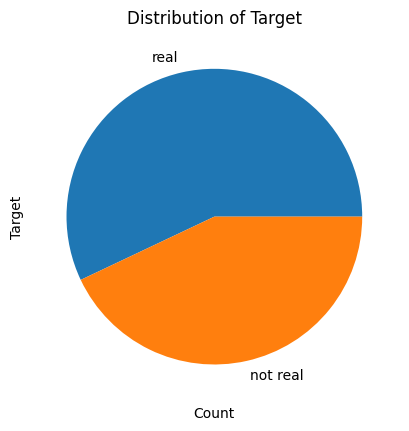

In [35]:
# train_df["target"].value_counts().plot(kind='barh', color='blue', alpha=0.7)
plt.pie(train_df["target"].value_counts(), labels=["real", "not real"])
plt.xlabel("Count")
plt.ylabel("Target")
plt.title("Distribution of Target")
plt.show()